# Siamese Neural Network


In [1]:
import torch
import torchvision
assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")



# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


In [2]:
import torchvision.datasets as dset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch 
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper function


In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Define model

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
BATCH_SIZE = 64
IMG_SIZE = (128,128)
PATCH_SIZE = (8,8)
# Number of patch in one sequence
NUM_PATCH = int((IMG_SIZE[0] / PATCH_SIZE[0])**2)
# Number of patch out after feature extracting
T = int(NUM_PATCH / 4)
# Number of attention head
NUM_H = 4
# Number of Transformer Block
NUM_TR = 11

In [6]:
my_transform = transforms.Compose([
                                    transforms.Resize((IMG_SIZE)),
                                    transforms.ToTensor()
])


In [7]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x


class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )



    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x


class Transpose(nn.Module):
    def __init__(self, dim1, dim2):
        super().__init__()
        self.dim1 = dim1
        self.dim2 = dim2

    def forward(self, x):
        return x.transpose(self.dim1, self.dim2)


class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim,n_feature, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size
        self.input_layer = nn.Sequential(
            nn.Conv3d(3 , n_feature*3 , kernel_size = 3 , padding=1 , stride=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,1,1) , stride=(2,1,1) , padding=(0,0,0)),

            nn.Conv3d(n_feature*3 , n_feature*6 , 3 , padding=1 , stride=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,1,1) , stride=(2,1,1) , padding=(0,0,0)),
            nn.Conv3d(n_feature*6 , n_feature*8 , 3 , padding=1 , stride=1),

            Transpose(2,1),
            nn.Flatten(2,-1),
            nn.Linear(n_feature*8*PATCH_SIZE[0]*PATCH_SIZE[0] ,embed_dim )


        )
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
            # torch.nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+int(NUM_PATCH / 4),embed_dim))


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size , flatten_channels=False).transpose(1,2)
        # print(x.shape)
        B, _, _ , _ , _= x.shape
        T = int(NUM_PATCH / 4)
        x = self.input_layer(x)
        # print(x.shape)
        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        # cls = x[0]
        # out = self.mlp_head(cls)
        return x

In [8]:
class SiamesNet (nn.Module):
    def __init__(self,use_pretrain=True):
        super().__init__()
        # Define model
        self.model = VisionTransformer(embed_dim = 256 ,
                            hidden_dim = 512,
                            n_feature=8 ,
                            num_channels = 3,
                            num_heads = NUM_H ,
                            num_layers = NUM_TR ,
                            num_classes=4,
                            patch_size=PATCH_SIZE[0] ,
                            num_patches=NUM_PATCH ,
                            dropout=0.1 ).to(device)
        # load model weights
        if (use_pretrain):
            name = "../../../../Ablation_Study/TrackExp/BestWeight_Part_19_Epoch_2_TrainLoss_0.01639417985006382_TestLoss_0.027976555515579093TrainAcc_0.9941451149425288_Testacc_0.9951171875.pth"
            # Compile the model
            torch.set_float32_matmul_precision('high')
            self.model = torch.compile(self.model)
            self.model.load_state_dict(torch.load(name))

    def forward_once(self, x):
        return self.model(x)

    def forward(self, Anchor, Positive , Negative):
        output1 = self.model(Anchor)
        output2 = self.model(Positive)
        output3 = self.model(Negative)
        return output1, output2 , output3

## Define Loss

In [9]:
# Define Loss function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Custom dataset

In [10]:
# Custom dataset 
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=my_transform):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        # Choose anchor
        Anchor = random.choice(self.imageFolderDataset.imgs)
        # we need to make sure approx 50% of images are in the same class
        # Choose a positive sample
        while True:
            #keep looping till the same class image is found
            Positive = random.choice(self.imageFolderDataset.imgs) 
            if Anchor[1]==Positive[1]:
                break
        # Choose a negative sample     
        while True:
            #keep looping till a different class image is found
            Negative = random.choice(self.imageFolderDataset.imgs) 
            if Anchor[1] !=Negative[1]:
                break

        Anchor = Image.open(Anchor[0])
        Positive = Image.open(Positive[0])
        Negative = Image.open(Negative[0])
        
        Anchor = Anchor.convert("RGB")
        Positive = Positive.convert("RGB")
        Negative = Negative.convert("RGB")
        

        if self.transform is not None:
            Anchor = self.transform(Anchor)
            Positive = self.transform(Positive)
            Negative = self.transform(Negative)
        
        return Anchor, Positive , Negative
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Define Config Class

In [11]:
class Config():
    training_dir = "../../../ICIP_denoised_data/Data_3/train/"
    train_batch_size = 16
    train_number_epochs = 50

## Define Dataset

In [12]:
!rm -rf ./data/train/.ipynb_checkpoints
!rm -rf ./data/test/.ipynb_checkpoints

In [13]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset)

## train model


In [14]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [15]:
next(iter(train_dataloader))[0].shape , next(iter(train_dataloader))[1].shape , next(iter(train_dataloader))[2].shape

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 128, 128]))

In [16]:
net = SiamesNet().to(device)
# criterion = ContrastiveLoss()
criterion = nn.TripletMarginLoss(margin=10)
optimizer = optim.SGD(net.parameters(),lr = 0.0005 )

Process ForkProcess-30:
Process ForkProcess-39:
Process ForkProcess-34:
Process ForkProcess-37:
Process ForkProcess-38:
Process ForkProcess-33:
Process ForkProcess-40:
Process ForkProcess-28:
Process ForkProcess-35:
Process ForkProcess-32:
Process ForkProcess-31:
Process ForkProcess-25:
Process ForkProcess-29:
Process ForkProcess-26:
Process ForkProcess-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/py

In [17]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 8.687236785888672



/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Epoch number 1
 Current loss 8.295820236206055

Epoch number 2
 Current loss 8.021916389465332

Epoch number 3
 Current loss 9.419677734375

Epoch number 4
 Current loss 8.93209457397461

Epoch number 5
 Current loss 8.553132057189941

Epoch number 6
 Current loss 9.236248970031738

Epoch number 7
 Current loss 9.522605895996094

Epoch number 8
 Current loss 10.005247116088867

Epoch number 9
 Current loss 8.001009941101074

Epoch number 10
 Current loss 6.374138832092285

Epoch number 11
 Current loss 7.87205171585083

Epoch number 12
 Current loss 6.134645938873291

Epoch number 13
 Current loss 6.685615539550781

Epoch number 14
 Current loss 5.171926498413086

Epoch number 15
 Current loss 2.2971599102020264

Epoch number 16
 Current loss 3.735102891921997

Epoch number 17
 Current loss 3.795198440551758

Epoch number 18
 Current loss 1.1903574466705322

Epoch number 19
 Current loss 2.4824979305267334

Epoch number 20
 Current loss 2.0956203937530518

Epoch number 21
 Current loss

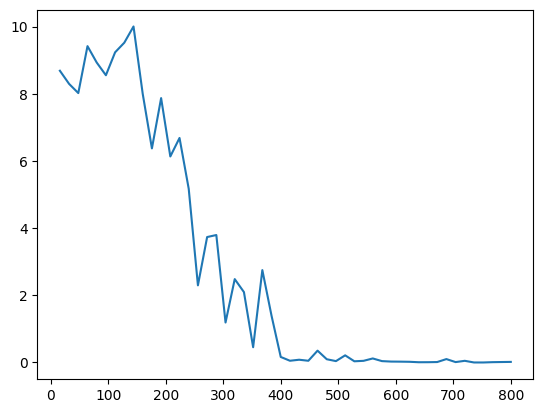

CPU times: user 1min 56s, sys: 27.9 s, total: 2min 24s
Wall time: 2min 37s


In [18]:
%%time
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        Anchor, Positive , Negative = data
        Anchor, Positive , Negative = Anchor.to(device), Positive.to(device) , Negative.to(device)
        optimizer.zero_grad()
        output1,output2 , output3 = net(Anchor, Positive , Negative)
        loss_contrastive = criterion(output1,output2,output3)
        loss_contrastive.backward()
        optimizer.step()
        if i %16 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=16
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Save model

In [19]:
# define path
path = "./TrackExp/"
torch.save(net.state_dict(),path + "siameseNet_50epoch_margin=10_calss_2_Normal(0)_Dme(1)_final_denoise.pth")

In [20]:
1 - 7 / 72

0.9027777777777778